In [1]:
%matplotlib notebook

import pymongo

import pandas as pd
import json
import numpy as np 

import matplotlib.pyplot as plt
from IPython.display import display

# Setup connections

In [2]:
client = pymongo.MongoClient()
db = client.airflow
cl = db.task_data
cl.estimated_document_count()

50

In [47]:
run = list(cl.find().limit(1))[0]

display(run["task_executions"][0].pop("resource_utilization")[0])

display(run["task_executions"][0])

{'time': 1575051415.849948,
 'cpu_times': {'user': 1.685919616,
  'system': 0.329816128,
  'children_user': 0.0,
  'children_system': 0.0},
 'virtual_memory': {'total': 17179869184,
  'available': 6593814528,
  'percent': 61.6,
  'used': 8327356416,
  'free': 1901682688,
  'active': 4695896064,
  'inactive': 4439769088,
  'wired': 3631460352},
 'swap_memory': {'total': 3221225472,
  'used': 1678245888,
  'free': 1542979584,
  'percent': 52.1,
  'sin': 136317890560,
  'sout': 323194880},
 'memory_info': {'rss': 113221632,
  'vms': 4690821120,
  'pfaults': 39161,
  'pageins': 0},
 'memory_usage': 113221632}

{'task_id': 'start',
 'inflow': [],
 'outflow': {'Date': '2015-12-29',
  'Open': 106.959999,
  'High': 109.43,
  'Low': 106.860001,
  'Close': 108.739998,
  'Volume': 30931200,
  'Adj Close': 108.15313200000001},
 'parents': [],
 'context': {'dag_id': 'test-multi-parent',
  'dagrun_id': 'manual__2019-11-29T18:16:51+00:00',
  'task_id': 'start',
  'ts': '2019-11-29T18:16:51+00:00'},
 'elapsed': 0.11162614822387695}

# Query for all runs of a given Task

In [10]:
def task_executions(dag, task):
    data = list(cl.find(
        {"dag": {"$eq": dag}, "task_executions.task_id": {"$eq": task}}, 
        {"task_executions.$": 1}
    ))
    data = [i["task_executions"] for i in data]
    return [i[0] for i in data]
    
# raw = task_executions("test-multi-parent", "start")

# Plot first dimension statistical summaries of task vector data

In [25]:
def d1_stats(raw, feature_lambda=lambda run: [m["memory_usage"] for m in run["resource_utilization"]]):
    data = []
    for run in raw:
        data.append(feature_lambda(run))
    df = pd.DataFrame(data ).transpose()

    df["min"] = df.min(axis=1).astype(float)
    df["max"] = df.max(axis=1).astype(float)
    df["mean"] = df.mean(axis=1).astype(float)
    df["median"] = df.median(axis=1).astype(float)
    
    return df[["min", "mean", "max", "median"]]


<IPython.core.display.Javascript object>


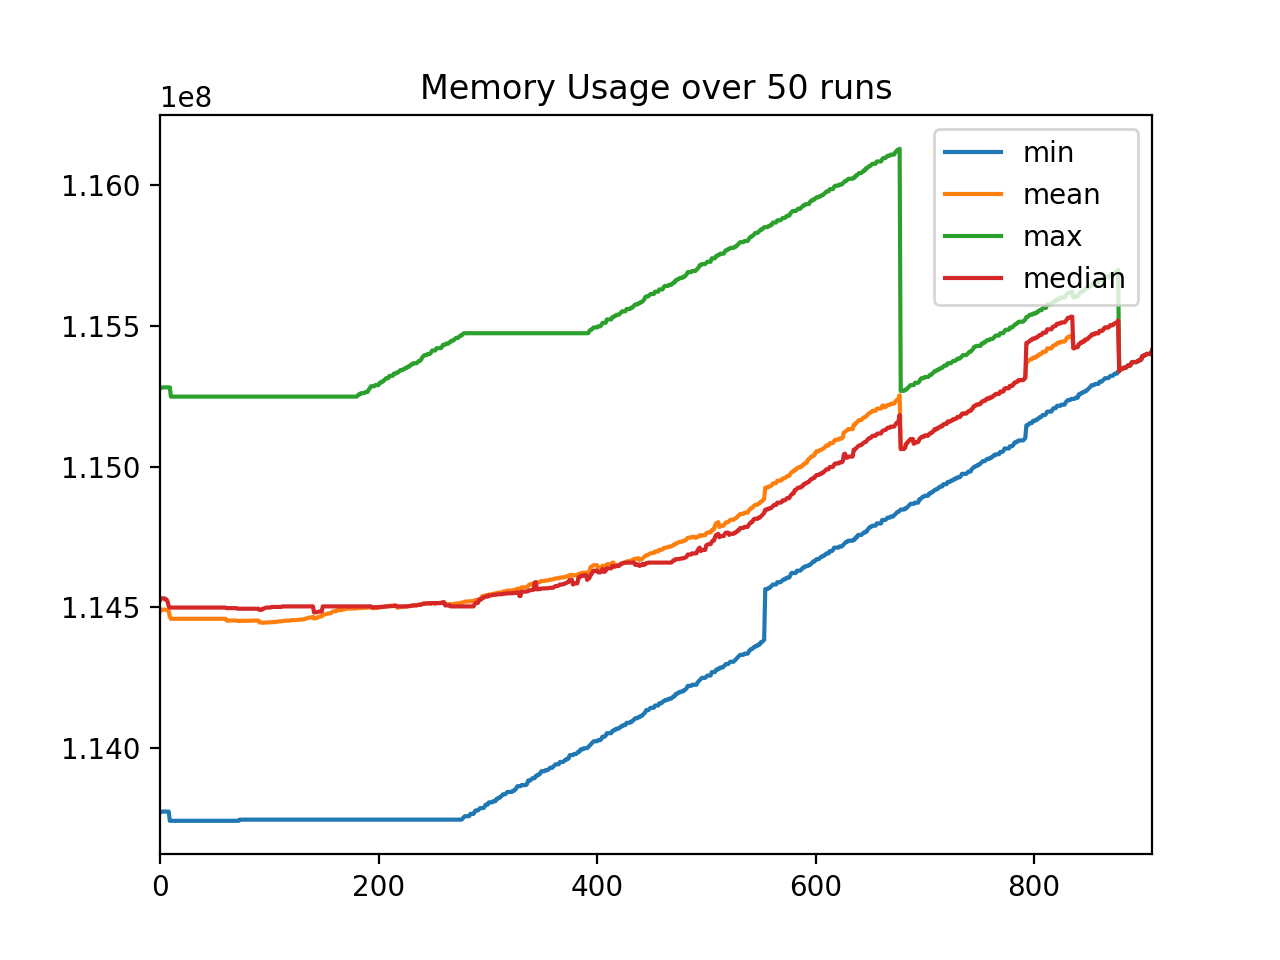

In [35]:
def plot_d1_stats(raw, feature_name="Memory Usage", feature_lambda=lambda run: [m["memory_usage"] for m in run["resource_utilization"]]):
    df = d1_stats(raw, feature_lambda)

    fig, ax = plt.subplots()
    df[["min", "mean", "max", "median"]].plot(ax=ax)
    plt.legend(loc='upper right')
    ax.set_title("{} over {} runs".format(feature_name, len(raw)))
    plt.show()
    
plot_d1_stats(task_executions("test-multi-parent", "handlerDiff"))    

# Plot scalar values from runs of a given task

<IPython.core.display.Javascript object>


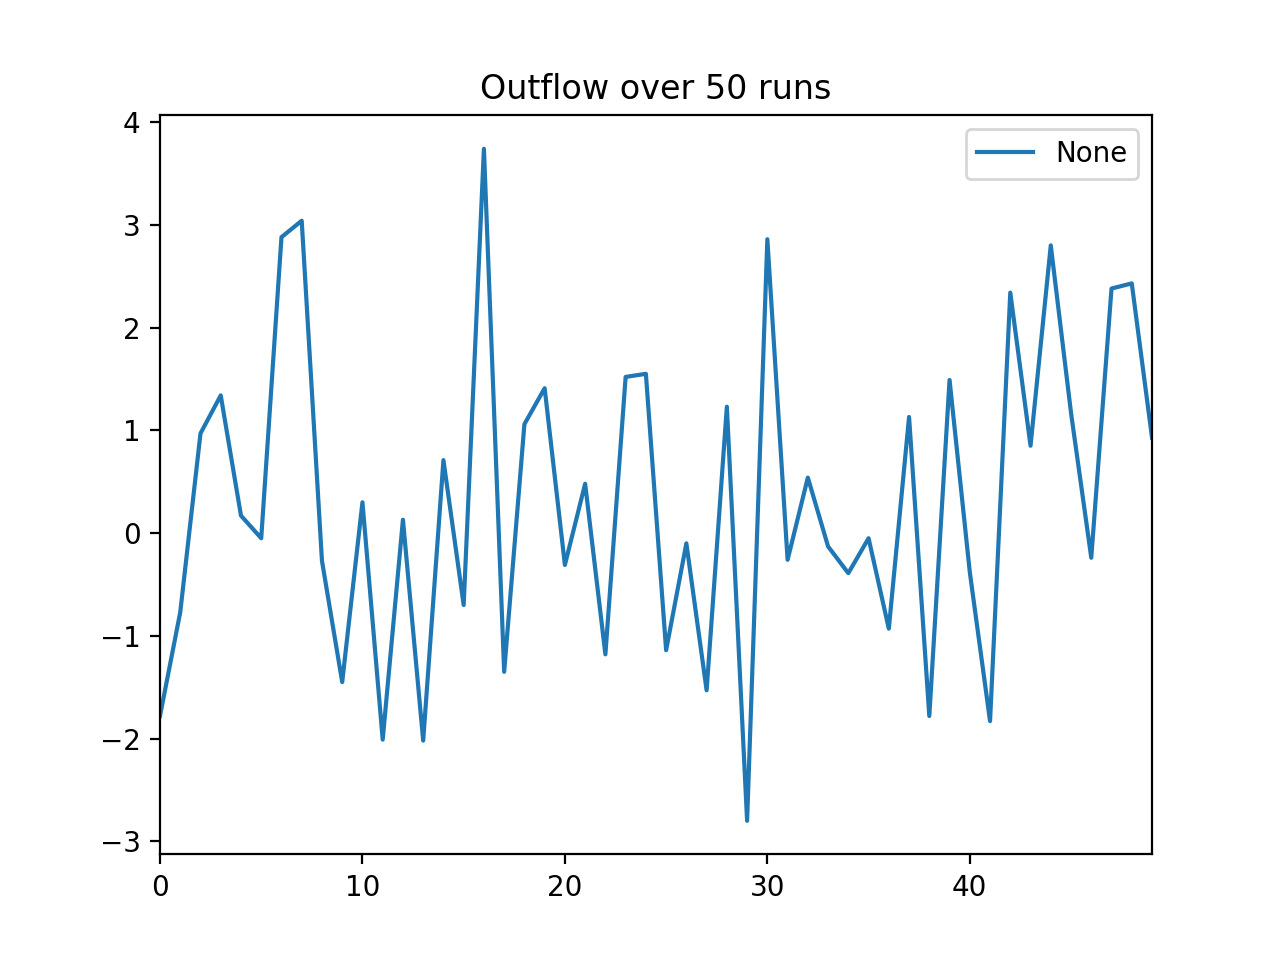

In [37]:
def plot_scalar(raw, feature_name="Outflow", feature_lambda=lambda run: run["outflow"]):
    data = [feature_lambda(i) for i in raw]
    s = pd.Series(data ).transpose()


    fig, ax = plt.subplots()
    s.plot(ax=ax)
    plt.legend(loc='upper right')
    ax.set_title("{} over {} runs".format(feature_name, len(raw)))
    plt.show()
    
plot_scalar(task_executions("test-multi-parent", "handlerDiff"))    